### Imports

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tqdm
from PIL import Image
import pickle

import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize

import gensim

[nltk_data] Error loading punkt: <urlopen error [WinError 10060] A
[nltk_data]     connection attempt failed because the connected party
[nltk_data]     did not properly respond after a period of time, or
[nltk_data]     established connection failed because connected host
[nltk_data]     has failed to respond>
C:\Users\OMEN\Anaconda3\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [97]:
import tensorflow
tensorflow.config.run_functions_eagerly(True)
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical

In [257]:
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, Embedding, LSTM, Dropout, TimeDistributed, MaxPooling2D, Masking, Add
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.vgg16 import preprocess_input
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [4]:
gensim.__version__

'3.6.0'

### Image Processing

In [261]:
image_model = VGG16(include_top=False, weights='imagenet',pooling='avg',input_shape=(224,224,3))
# image_model = ResNet50(include_top=False, weights='imagenet',pooling='avg',input_shape=(224,224,3))

In [194]:
image_feature_mapping = {}

In [195]:
image_folder = "Images"

for each in tqdm.tqdm(os.listdir(image_folder)):
    img = load_img(f"{image_folder}/{each}", target_size=(224,224,3))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    features = image_model.predict(img_array)
    image_feature_mapping[each] = np.squeeze(features)

100%|██████████████████████████████████████████████████████████████████████████████| 8091/8091 [12:20<00:00, 10.92it/s]


In [196]:
# with open( "saved/image_feature_mapping_vgg.p", "wb" ) as f:
#     pickle.dump(image_feature_mapping, f )
    
with open( "saved/image_feature_mapping_resnet.p", "wb" ) as f:
    pickle.dump(image_feature_mapping, f )

In [197]:
np.shape(image_feature_mapping['667626_18933d713e.jpg'])

(2048,)

### Text Processing

In [198]:
len(os.listdir("Images"))

8091

In [199]:
df = pd.read_csv('captions.txt')
print(df.shape)
df.head()

(40455, 2)


,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


In [200]:
df.isnull().sum()

image      0
caption    0
dtype: int64

In [201]:
def tokenize_with_tag(text):
    text = text.lower()
    text = word_tokenize(text)
    text.insert(0,'<start>')
    text.append('<end>')
    return text

df['tokenize'] = df['caption'].apply(tokenize_with_tag)

In [202]:
df['word_count'] = df['tokenize'].str.len()

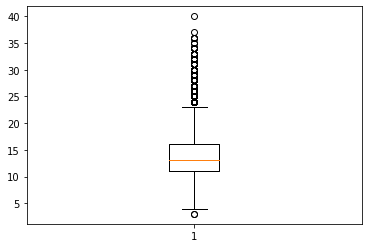

In [203]:
plt.boxplot(df['word_count'])
plt.show()

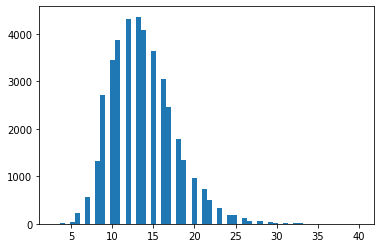

In [204]:
plt.hist(df['word_count'], bins=60)
plt.show()

In [205]:
max_length = 18
min_length = 8
df = df[df['word_count']<=max_length]
df = df[df['word_count']>=min_length]

In [206]:
df.shape

(35030, 4)

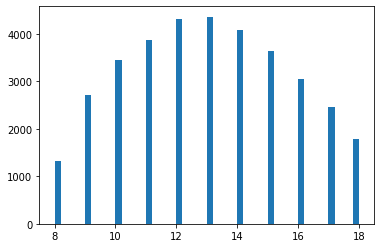

In [207]:
plt.hist(df['word_count'], bins=50)
plt.show()

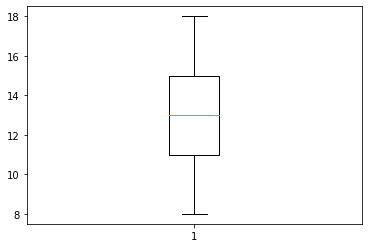

In [208]:
plt.boxplot(df['word_count'])
plt.show()

In [209]:
df.head()

,image,caption,tokenize,word_count
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .,"[<start>, a, girl, going, into, a, wooden, bui...",10
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .,"[<start>, a, little, girl, climbing, into, a, ...",11
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...,"[<start>, a, little, girl, climbing, the, stai...",12
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...,"[<start>, a, little, girl, in, a, pink, dress,...",15
5,1001773457_577c3a7d70.jpg,A black dog and a spotted dog are fighting,"[<start>, a, black, dog, and, a, spotted, dog,...",11


In [210]:
count_column = df['tokenize']
count_dict = {}

for each in count_column:
    for i in each:
        if i in count_dict:
            count_dict[i] += 1
        else:
            count_dict[i] = 1

In [211]:
threshold = 5

vocab_dict = {key: value for key, value in count_dict.items() if value > threshold}

In [212]:
sentences = []

for each in df['tokenize']:
    temp = []
    for i in each:
        if i in vocab_dict:
            temp.append(i)
        else:
            temp.append('<out>')
    sentences.append(temp)

In [213]:
w2v_model = gensim.models.Word2Vec(sentences=sentences,size=256,window=10,min_count=1)
w2v_model.train(sentences,epochs=10,total_examples=len(sentences))

(2360605, 4549140)

In [214]:
print(f"Total number of words are {len(w2v_model.wv.vocab)}")

Total number of words are 2374


In [215]:
vocab = {k for k,v in w2v_model.wv.vocab.items()}
vocab_length = len(w2v_model.wv.vocab)

In [216]:
# create embedding matrix
embed_dim = 256
embed_matrix=np.zeros(shape=(vocab_length,embed_dim))

for i,word in enumerate(vocab):
    if word == '<out>':
        embed_matrix[i]=np.zeros(embed_dim)
    else:
        embed_vector=w2v_model.wv.get_vector(word)
        embed_matrix[i]=embed_vector

In [217]:
np.shape(embed_matrix)

(2374, 256)

In [218]:
word_to_id = {}
id_to_word = {}

for i,each in enumerate(vocab):
    word_to_id[each] = i
    id_to_word[i] = each

In [219]:
word_to_id['<out>'], word_to_id['<start>'], word_to_id['<end>']

(11, 799, 1767)

In [220]:
one_hot_sentences = []
max_length = 0

for each in sentences:
    temp = []
    for i in each:
        if i in word_to_id:
            temp.append(word_to_id[i])
        else:
            temp.append(word_to_id['<out>'])

    if len(temp)>max_length:
        max_length = len(temp)

    one_hot_sentences.append(temp)

print(f"max length: {max_length}")

max length: 18


In [221]:
true_caption = pad_sequences(one_hot_sentences, maxlen=max_length, padding='post')

In [224]:
df['true_caption'] = true_caption.tolist()

In [225]:
df = df[['image','caption','true_caption']]
df = df.sample(frac=1).reset_index(drop=True)
df.head()

,image,caption,true_caption
0,2599131872_65789d86d5.jpg,Two girls with long hair jumping on a trampoli...,"[799, 286, 518, 2343, 135, 1657, 1478, 2052, 2..."
1,3430287726_94a1825bbf.jpg,a man in a black outfit is riding a blue snowm...,"[799, 2059, 1897, 1477, 2059, 797, 2006, 2127,..."
2,244399048_8332bb3270.jpg,Dog jumping up with something in its mouth .,"[799, 1118, 1478, 257, 2343, 1665, 1477, 759, ..."
3,2828583747_8cfb7217af.jpg,A child in red short and orange cap in a parki...,"[799, 2059, 1832, 1477, 1038, 869, 817, 1072, ..."
4,581419370_30485f3580.jpg,Two people are jumping on a bridge in the moun...,"[799, 286, 1268, 34, 1478, 2052, 2059, 120, 14..."


In [309]:
df.shape

(35030, 3)

### Batch Loading

In [266]:
with open('saved/image_feature_mapping_vgg.p', 'rb') as f:
    image_feature_mapping = pickle.load(f)

In [267]:
data_dir = "Images" 

filenames = [fname for fname in df.image]
captions = [each for each in df.true_caption]

train_images, train_captions = [], []
val_images, val_captions = [], []

for i in range(np.shape(filenames)[0]):
    if i%8==0:
        val_images.append(filenames[i])
        val_captions.append(captions[i])
    else:
        train_images.append(filenames[i])
        train_captions.append(captions[i])

In [268]:
print(np.shape(train_images), np.shape(train_captions))
print(np.shape(val_images), np.shape(val_captions))

(30651,) (30651, 18)
(4379,) (4379, 18)


In [269]:
print(train_images[0])

3430287726_94a1825bbf.jpg


In [270]:
len(train_images)

30651

In [271]:
print(train_captions[0])

[799, 2059, 1897, 1477, 2059, 797, 2006, 2127, 35, 2059, 1008, 793, 40, 960, 976, 255, 1767, 0]


In [272]:
def batch_generator(gen, batch_size):

    file_names = train_images
    captions = train_captions
    length = len(train_images)

    if gen == 'val':
        file_names = val_images
        captions = val_captions
        length = len(val_images)

   # Loop over the file paths and load the images in batches
    while True:
        for i in range(0, length, batch_size):
            batch_filenames = file_names[i:i+batch_size]
            batch_captions = captions[i:i+batch_size]
            x_image, x_caption, y = [], [], []

            for filename, caption in zip(batch_filenames, batch_captions):
                for j in range(1,max_length):
                    current_sequence = caption[0:j]
                    target_word = caption[j]
                    current_sequence = pad_sequences([current_sequence], maxlen=max_length, padding='post')
                    one_hot_target_word = to_categorical([target_word], vocab_length)[0]
                    x_image.append(image_feature_mapping[filename])
                    x_caption.append(current_sequence)
                    y.append(one_hot_target_word)
            yield (np.array(x_image), np.array(x_caption).squeeze()), np.array(y)

### Modelling

In [291]:
image_input = Input(shape=(512,), name='image_i/p')
image_output = Dense(256,activation='relu', name='image_dense')(image_input)

text_input = Input(shape=(max_length,), name='text_i/p')
embed = Embedding(input_dim=vocab_length, output_dim=256, weights=[embed_matrix], trainable=False, name='embeddings')
text_embed = embed(text_input)
lstm = LSTM(256, name='lstm')
text_output = lstm(text_embed)

combine = Add()([image_output, text_output])
final_dense = Dense(256,activation='relu', name='combine_dense')(combine)
final_output = Dense(vocab_length, activation='softmax', name='final_dense')(final_dense)

model = Model(inputs=[image_input,text_input], outputs=final_output)
model.compile(loss=tensorflow.keras.losses.CategoricalCrossentropy(),metrics=['accuracy'],optimizer='adam')

In [292]:
model.summary()

Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text_i/p (InputLayer)          [(None, 18)]         0           []                               
                                                                                                  
 image_i/p (InputLayer)         [(None, 512)]        0           []                               
                                                                                                  
 embeddings (Embedding)         (None, 18, 256)      607744      ['text_i/p[0][0]']               
                                                                                                  
 image_dense (Dense)            (None, 256)          131328      ['image_i/p[0][0]']              
                                                                                           

In [293]:
# # Define the file path for saving the model weights
# checkpoint_filepath = 'saved/weights/model.{epoch:02d}.h5'

# # Create a ModelCheckpoint callback that saves the best model weights based on validation accuracy
# checkpoint_callback = ModelCheckpoint(
#     checkpoint_filepath,
#     monitor='val_accuracy',
#     verbose=1,
#     save_best_only=True,
#     save_weights_only=True,
#     mode='max'
# )

# # # Create an EarlyStopping callback that stops training when validation accuracy reaches 0.95
# # early_stopping_callback = EarlyStopping(
# #     monitor='val_acc',
# #     verbose=1,
# #     baseline=0.95
# # )

In [294]:
epochs = 10
batch_size = 32
train_steps = len(train_images)//batch_size
val_steps = len(val_images)//batch_size

In [295]:
train_generator = batch_generator('train', batch_size)
val_generator = batch_generator('val', batch_size)

In [ ]:
history = model.fit(train_generator, steps_per_epoch=train_steps, 
                    epochs=epochs, validation_data=val_generator, validation_steps=val_steps)

In [300]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

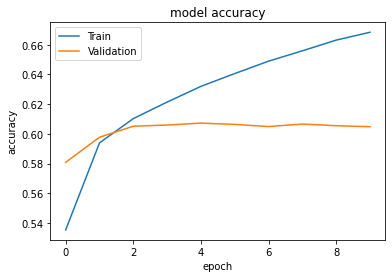

In [301]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

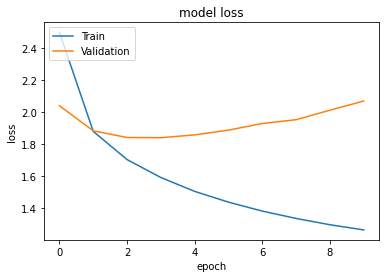

In [302]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [305]:
model.save('saved/vgg16_image_captioning.h5')

### Inference

In [303]:
def generate_captions(filepath1):
    image = load_img(filepath1, target_size=(224, 224))
    img_array = img_to_array(image)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    img_array = image_model.predict(img_array)

    caption = '<start>'

    for i in range(max_length):
        sequence = [word_to_id[i] if i in word_to_id else word_to_id['<out>'] for i in caption.split(' ')]
        sequence = pad_sequences([sequence], maxlen=max_length, padding='post')
        pred = model.predict([img_array, sequence], verbose=0)
        pred = np.argmax(pred[0])
        word = id_to_word[pred]
        
        if word != '<end>':
            caption += ' ' + word
        else:
            break
    return caption[8:]

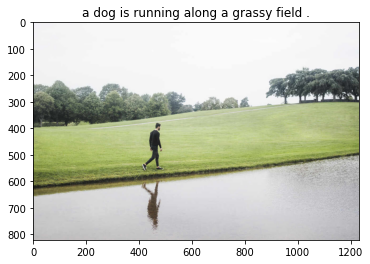

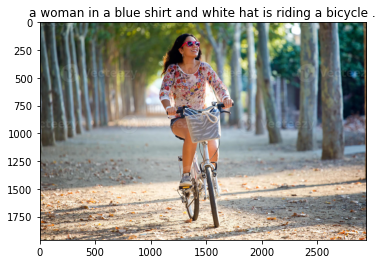

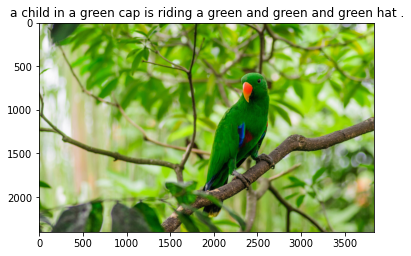

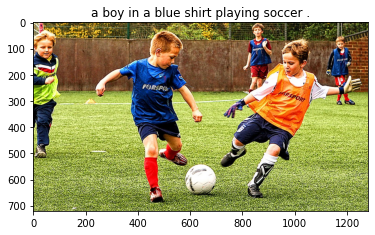

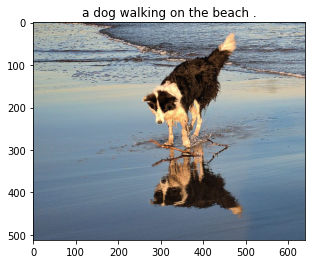

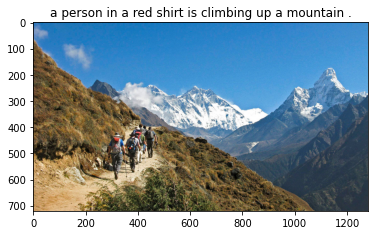

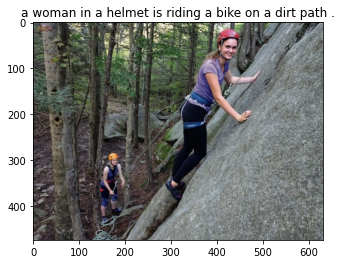

In [308]:
for i in os.listdir('test'):
    test_path = f'test/{i}'
    test_image = Image.open(test_path)
    plt.imshow(test_image)
    plt.title(generate_captions(test_path))
    plt.show()

### Loading

In [258]:
new_model = load_model('saved/vgg16_image_captioning.h5')

In [262]:
def generate_test_captions(filepath1):
    image = load_img(filepath1, target_size=(224, 224))
    img_array = img_to_array(image)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    img_array = image_model.predict(img_array)

    caption = '<start>'

    for i in range(max_length):
        sequence = [word_to_id[i] if i in word_to_id else word_to_id['<out>'] for i in caption.split(' ')]
        sequence = pad_sequences([sequence], maxlen=max_length, padding='post')
        pred = new_model.predict([img_array, sequence], verbose=0)
        pred = np.argmax(pred[0])
        word = id_to_word[pred]
        
        if word != '<end>':
            caption += ' ' + word
        else:
            break
    return caption[8:]

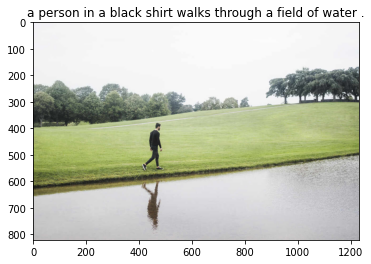

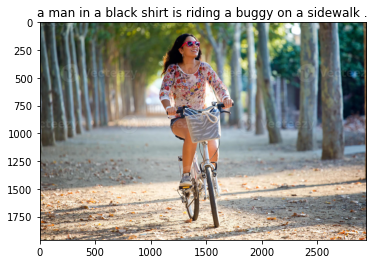

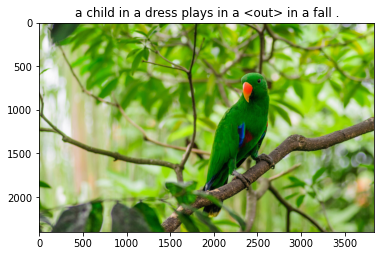

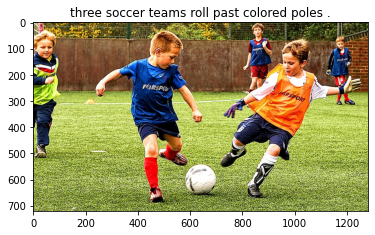

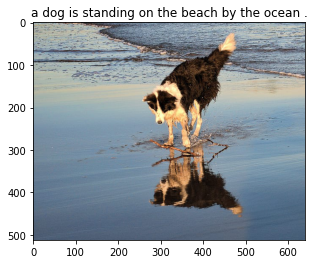

In [264]:
for i in os.listdir('test'):
    test_path = f'test/{i}'
    test_image = Image.open(test_path)
    plt.imshow(test_image)
    plt.title(generate_test_captions(test_path))
    plt.show()